In [1]:
import sys
sys.path.append('scripts')
from data_generator import *
from draw_data import *

In [18]:
def data_process(SUBJ, 
                 RESULTS='/Volumes/BPlus/primeRec/results/',
                 DATA='/Volumes/BPlus/primeRec/data/'):
     
    dg = DataGenerator(SUBJ, RESULTS, DATA)
    info_list = dg.get_info_list()
    lat_arr = dg.get_latent(info_list)
    voxel_arr = dg.get_voxel(info_list)
    voxel_cut = voxel_arr[:, 10:80, 10:60, 10:60]
    
    return voxel_cut, lat_arr

In [121]:
x, y = data_process('sub02')
x.shape, y.shape

* number of infos: 1000
* smaple info:
[[1, 1], '/Volumes/BPlus/primeRec/results//sub02/trial_wise/phase1_trialWiseGLM_train_run1.feat/stats/tstat1_mask1.nii.gz', [1, 583]]


((1000, 70, 50, 50), (1000, 100))

In [116]:
def cut_value(x, val=5):
    x[x<-val]=-val
    x[x>val]=val
    return x

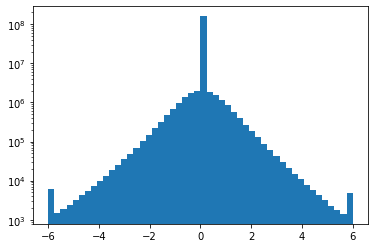

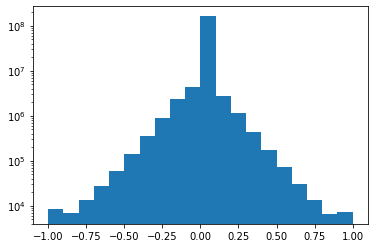

In [126]:
hist_data(x_cut, bins=50)
hist_data(x_nor)

In [113]:
def hist_data(data, bins=20):
    data = data.reshape((data.shape[0]*data.shape[1]*data.shape[2]*data.shape[3]))
    plt.hist(data, bins=bins, log=True)
    plt.show()

In [146]:
def z_normalize(x):
    x_nor = (x - 0) / np.std(x)
    return x_nor
def minmax_normalize(x, mean=0):
    x = x - mean / np.max(x) 
    return x

In [129]:
for idx, sub in enumerate(['sub02', 'sub19', 'sub21', 'sub22', 'sub23','sub24']):
    x, y = data_process(sub)
    x = cut_value(x, val=6)
    x = minmax_normalize(x)
    print(idx, sub, x.shape, y.shape)
    
    if idx==0:
        x_concat = x
        y_concat = y
    else: 
        x_concat = np.concatenate((x_concat, x))
        y_concat = np.concatenate((y_concat, y))
    print(x_concat.shape, y_concat.shape)
    print('-------------------------------------')

* number of infos: 1000
* smaple info:
[[1, 1], '/Volumes/BPlus/primeRec/results//sub02/trial_wise/phase1_trialWiseGLM_train_run1.feat/stats/tstat1_mask1.nii.gz', [1, 583]]
0 sub02 (1000, 70, 50, 50) (1000, 100)
(1000, 70, 50, 50) (1000, 100)
-------------------------------------
* number of infos: 1000
* smaple info:
[[1, 1], '/Volumes/BPlus/primeRec/results//sub19/trial_wise/phase1_trialWiseGLM_train_run1.feat/stats/tstat1_mask1.nii.gz', [2, 219]]
1 sub19 (1000, 70, 50, 50) (1000, 100)
(2000, 70, 50, 50) (2000, 100)
-------------------------------------
* number of infos: 1000
* smaple info:
[[1, 1], '/Volumes/BPlus/primeRec/results//sub21/trial_wise/phase1_trialWiseGLM_train_run1.feat/stats/tstat1_mask1.nii.gz', [1, 23]]
2 sub21 (1000, 70, 50, 50) (1000, 100)
(3000, 70, 50, 50) (3000, 100)
-------------------------------------
* number of infos: 1000
* smaple info:
[[1, 1], '/Volumes/BPlus/primeRec/results//sub22/trial_wise/phase1_trialWiseGLM_train_run1.feat/stats/tstat1_mask1.nii.

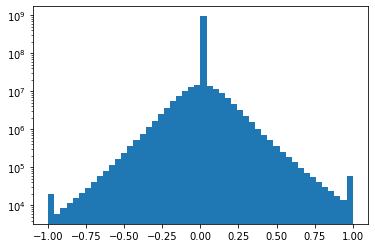

In [130]:
hist_data(x_concat, bins=50)

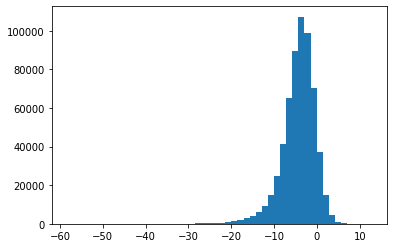

In [145]:
plt.hist(y_concat.reshape(y_nor.shape[0]*100), bins=50)
plt.show()

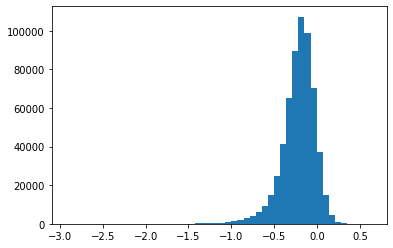

In [148]:
y_nor = y_concat/20
plt.hist(y_nor.reshape(y_nor.shape[0]*100), bins=50)
plt.show()

In [149]:
x_data = np.expand_dims(x_concat, axis=4)
x_data.shape

(6000, 70, 50, 50, 1)

In [150]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_concat, test_size=0.1, shuffle=True)
x_train.shape, x_test.shape

((5400, 70, 50, 50, 1), (600, 70, 50, 50, 1))

In [54]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers

In [151]:
model = models.Sequential()
model.add(layers.Input(shape=(70,50,50,1)))
model.add(layers.Conv3D(16, strides=2, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(layers.Conv3D(32, strides=2, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(100))

In [152]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 34, 24, 24, 16)    448       
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 17, 12, 12, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 8, 5, 5, 32)       13856     
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 4, 2, 2, 32)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 100)             

In [153]:
model.compile(loss=losses.mse,
              optimizer=optimizers.Adam(lr=0.001))

In [154]:
history = model.fit(x_train, y_train,
            batch_size=16,
            epochs=10,
            validation_split=0.2)

Train on 4320 samples, validate on 1080 samples
Epoch 1/10
4320/4320 [==============================] - 128s 30ms/sample - loss: 14.2599 - val_loss: 13.0893
Epoch 2/10
4320/4320 [==============================] - 117s 27ms/sample - loss: 12.9438 - val_loss: 13.1165
Epoch 3/10
4320/4320 [==============================] - 116s 27ms/sample - loss: 12.8992 - val_loss: 13.0733
Epoch 4/10
4320/4320 [==============================] - 117s 27ms/sample - loss: 12.8925 - val_loss: 13.0941
Epoch 5/10
4320/4320 [==============================] - 119s 27ms/sample - loss: 12.8579 - val_loss: 13.0550
Epoch 6/10
4320/4320 [==============================] - 116s 27ms/sample - loss: 12.8773 - val_loss: 13.0552
Epoch 7/10
4320/4320 [==============================] - 117s 27ms/sample - loss: 12.8304 - val_loss: 13.1405
Epoch 8/10
4320/4320 [==============================] - 120s 28ms/sample - loss: 12.7764 - val_loss: 13.1485
Epoch 9/10
4320/4320 [==============================] - 123s 28ms/sample - loss:

In [155]:
y_pred = model.predict(x_test)
x_test.shape, y_test.shape, y_pred.shape, 

((600, 70, 50, 50, 1), (600, 100), (600, 100))

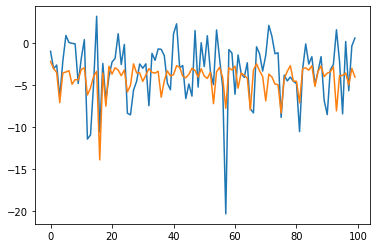

In [168]:
plt.plot(y_test[0])
plt.plot(y_pred[1])

In [167]:
for i in range(10):
    co = np.mean(abs(y_test[0]-y_pred[i]))
    print(co)

2.597286
2.5054264
2.4592962
2.5766199
2.5554063
2.6228921
2.474128
2.4229999
2.586851
2.5823324


In [161]:
co

array([[1.        , 0.47215575],
       [0.47215575, 1.        ]])

In [157]:
corr, self_corr, other_corr = get_corr(y_test, y_pred)

In [67]:
def get_corr(y_test, y_pred):

    corr=[]
    self_sum, other_sum = 0, 0
    self_n, other_n = 0, 0
    for ti, y_t in enumerate(y_test):
        corr_row=[]
        for pi, y_p in enumerate(y_pred):
            co = np.corrcoef(y_t, y_p)[0][1]
            corr_row.append(co)
            if ti==pi:
                #print(ti, pi, co)
                self_sum +=co
                self_n+=1
            else:
                other_sum +=co
                other_n+=1
        corr.append(corr_row)
    corr = np.array(corr)
    self_corr = self_sum/self_n
    other_corr = other_sum/other_n

    return corr, self_corr, other_corr

In [158]:
self_corr, other_corr

(0.4333417781793105, 0.43357831229060745)

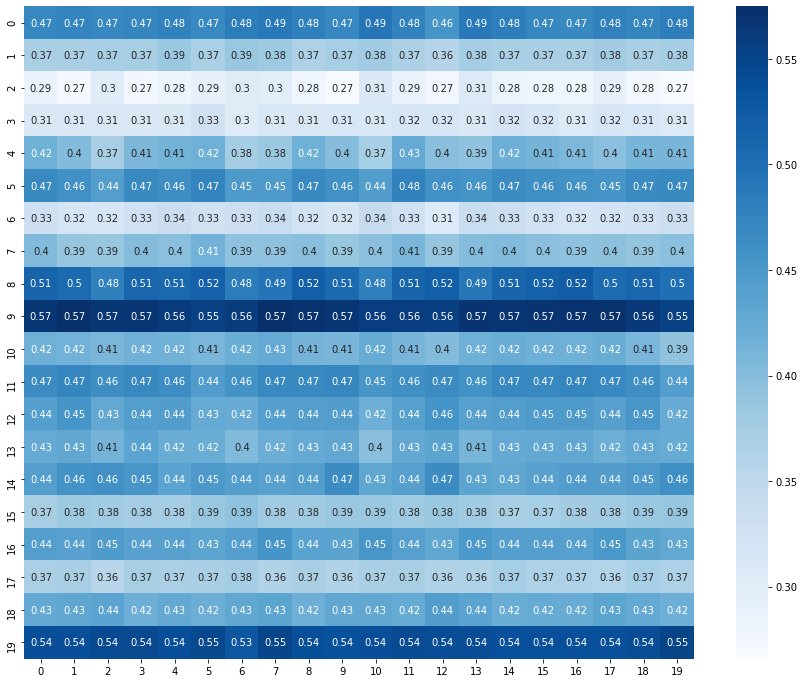

In [159]:
draw_heatmap(corr[:20,:20])